In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# project root
project_root = Path.cwd()

# data directories
train_dir = project_root / "data" / "train_files"
supplemental_dir = project_root / "data" / "supplemental_files"

# results directory
results_dir = project_root / "results"

In [3]:
# load the data

stock_prices = pd.read_csv(train_dir / "stock_prices.csv")
secondary_stock_prices = pd.read_csv(train_dir / "secondary_stock_prices.csv")
stock_prices_supplemental = pd.read_csv(supplemental_dir / "stock_prices_supplemental.csv")
secondary_stock_prices_supplemental = pd.read_csv(supplemental_dir / "secondary_stock_prices_supplemental.csv")

In [4]:
stock_prices_all = pd.concat(
    [
        stock_prices,
        secondary_stock_prices,
        stock_prices_supplemental,
        secondary_stock_prices_supplemental
    ],
    ignore_index=True
)

stock_prices_all.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [5]:
df = stock_prices_all.drop_duplicates(subset=["Date", "SecuritiesCode"], keep="last")
df["Date"] = pd.to_datetime(df["Date"])
df["ExpectedDividend"] = df["ExpectedDividend"].fillna(0)
df["SupervisionFlag"] = df["SupervisionFlag"].astype(int)
df = df.drop(columns=["RowId", "AdjustmentFactor"])
df = df.dropna(subset = ["Target"])
df.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,ExpectedDividend,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.0,0,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,0.0,0,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,0.0,0,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,0.0,0,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,0.0,0,0.003026


In [6]:
df = df.sort_values(["SecuritiesCode", "Date"]).reset_index(drop=True)
ohlc = ["Open", "High", "Low", "Close"]

df[ohlc] = (
    df.groupby("SecuritiesCode")[ohlc]
      .apply(lambda g: g.interpolate().ffill().bfill())
      .reset_index(level = 0, drop=True)
)

df[ohlc].isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [7]:
# Daily Features

df["Daily_Range"] = df["Close"] - df["Open"]
df["Mean"] = (df["High"] + df["Low"]) / 2
df.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,ExpectedDividend,SupervisionFlag,Target,Daily_Range,Mean
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.0,0,0.000730,8.0,2742.5
1,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,0.0,0,0.002920,-5.0,2741.0
2,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,0.0,0,-0.001092,6.0,2732.0
3,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,0.0,0,-0.005100,3.0,2744.5
4,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,0.0,0,-0.003295,-3.0,2744.5


In [8]:
# Momentum and returns

df["Return_1d"] = df.groupby("SecuritiesCode")["Close"].pct_change()
df["Return_7d"] = df.groupby("SecuritiesCode")["Close"].pct_change(7)
df["Return_30d"] = df.groupby("SecuritiesCode")["Close"].pct_change(30)

In [9]:
# Volatility features

df["Volatility_7"] = (
    df.groupby("SecuritiesCode")["Close"]
      .rolling(7)
      .std()
      .reset_index(level=0, drop=True)
)

df["Volatility_30"] = (
    df.groupby("SecuritiesCode")["Close"]
      .rolling(30)
      .std()
      .reset_index(level=0, drop=True)
)

In [10]:
# Volume features

df["Volume_Avg_7"] = (
    df.groupby("SecuritiesCode")["Volume"]
      .rolling(7)
      .mean()
      .reset_index(level=0, drop=True)
)

df["Volume_Avg_30"] = (
    df.groupby("SecuritiesCode")["Volume"]
      .rolling(30)
      .mean()
      .reset_index(level=0, drop=True)
)

In [11]:
df = df.dropna(subset=[
    "Return_1d", "Return_7d", "Return_30d",
    "Volatility_7", "Volatility_30",
    "Volume_Avg_7", "Volume_Avg_30",
    "Target"
])

In [12]:
split_date = df["Date"].quantile(0.8)
print("Split date:",split_date)

Split date: 2021-06-14 00:00:00


In [13]:
train_df = df[df["Date"] < split_date].copy()
test_df  = df[df["Date"] >= split_date].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))

Train rows: 4106905
Test rows: 1031235


In [14]:
exclude = ["Date", "Target", "SecuritiesCode"]

X_train = train_df.drop(columns = exclude)
y_train = train_df["Target"]

X_test  = test_df.drop(columns = exclude)
y_test  = test_df["Target"]

print("NaN in y_train:", y_train.isna().sum())
print("NaN in y_test:", y_test.isna().sum())

NaN in y_train: 0
NaN in y_test: 0


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_leaf = 50,
    max_depth = 10,
    n_jobs = -1,
    random_state = 42,
    verbose = 1
)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.3s finished


In [19]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", r2)
print("RMSE:", rmse)

R^2: 0.002699412198781115
RMSE: 0.024743819372713232


Feature Importance:
             Feature  Importance
5   ExpectedDividend    0.160815
9          Return_1d    0.141970
10         Return_7d    0.115158
0               Open    0.098593
7        Daily_Range    0.079832
11        Return_30d    0.076674
4             Volume    0.056700
15     Volume_Avg_30    0.053631
14      Volume_Avg_7    0.042481
12      Volatility_7    0.039994
13     Volatility_30    0.032957
8               Mean    0.032688
3              Close    0.022008
1               High    0.020480
2                Low    0.019508
6    SupervisionFlag    0.006509


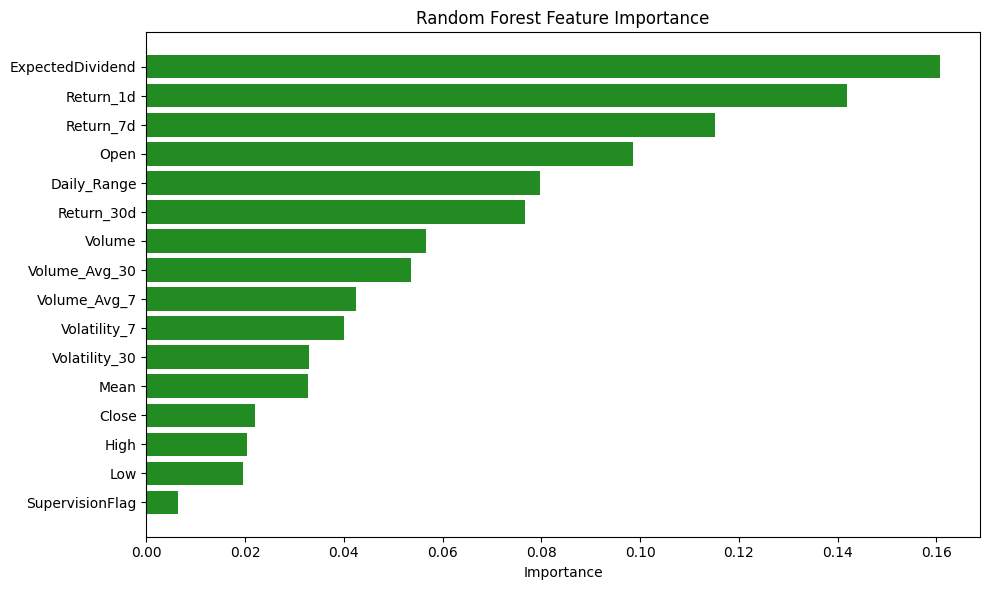

In [20]:
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
save_path = results_dir / "random_forest_features.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [24]:
def calculate_sharpe_ratio(test_df, predictions, portfolio_size=200, toprank_weight_ratio=2):
    """
    Correct JPX Competition Sharpe Ratio with weighted returns.
    """
    df_eval = test_df.copy()
    df_eval['Prediction'] = predictions

    daily_spread_returns = []

    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)

    for date in df_eval['Date'].unique():
        day_data = df_eval[df_eval['Date'] == date].copy()

        if len(day_data) >= portfolio_size * 2:
            day_data['Rank'] = day_data['Prediction'].rank(ascending=False) - 1
            day_data = day_data.sort_values('Rank')

            top_returns = day_data.head(portfolio_size)['Target'].values
            purchase = (top_returns * weights).sum() / weights.sum()

            bottom_returns = day_data.tail(portfolio_size)['Target'].values[::-1]
            short = (bottom_returns * weights).sum() / weights.sum()

            spread_return = purchase - short
            daily_spread_returns.append(spread_return)

    daily_spread_returns = np.array(daily_spread_returns)

    if len(daily_spread_returns) > 0 and daily_spread_returns.std() > 0:
        sharpe = daily_spread_returns.mean() / daily_spread_returns.std()
    else:
        sharpe = 0

    return sharpe, daily_spread_returns

sharpe, spread_returns = calculate_sharpe_ratio(test_df, y_pred)

print("JPX Sharpe Ratio:", sharpe)
print("Mean daily spread:", spread_returns.mean())
print("Std daily spread:", spread_returns.std())
print("Days evaluated:", len(spread_returns))

sharpe_summary = pd.DataFrame({
    "metric": [
        "jpx_sharpe_ratio",
        "mean_daily_spread",
        "std_daily_spread",
        "days_evaluated"
    ],
    "value": [
        sharpe,
        spread_returns.mean(),
        spread_returns.std(),
        len(spread_returns)
    ]
})
save_path = results_dir / "random_forest_sharpe_metrics.csv"
sharpe_summary.to_csv(save_path, index=False)

JPX Sharpe Ratio: 0.3886000649623166
Mean daily spread: 0.003138895414830073
Std daily spread: 0.008077444390377183
Days evaluated: 253


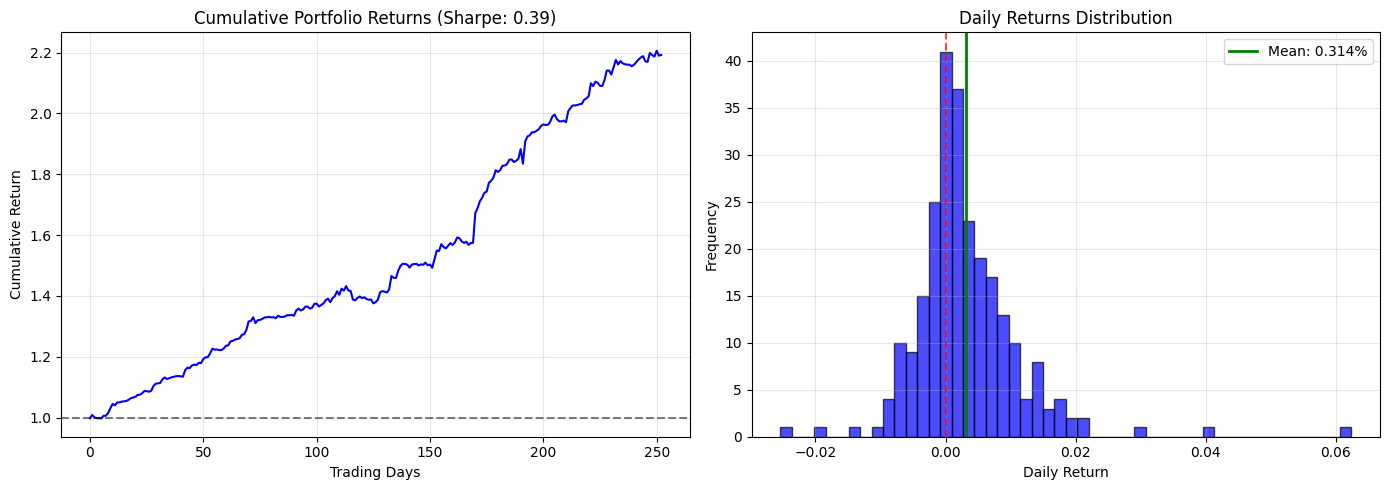

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns
ax1 = axes[0]
cumulative = (1 + pd.Series(spread_returns)).cumprod()
ax1.plot(cumulative, color='blue', linewidth=1.5)
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax1.set_title(f'Cumulative Portfolio Returns (Sharpe: {sharpe:.2f})')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)

# Daily returns distribution
ax2 = axes[1]
ax2.hist(spread_returns, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax2.axvline(x=np.mean(spread_returns), color='green', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(spread_returns)*100:.3f}%')
ax2.set_title('Daily Returns Distribution')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save_path = results_dir / "random_forest_sharpe_plots.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

## ABLATION

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

top_features = [
    'ExpectedDividend',
    'Return_1d',
    'Return_7d',
    'Open',
    'Daily_Range',
    'Return_30d',
    'Volume'
]

X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

print(f"Original features: {len(X_train.columns)}")
print(f"Reduced features: {len(top_features)}")

rf_reduced = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = rf_reduced.predict(X_test_reduced)

r2_reduced = r2_score(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred_reduced))

Original features: 16
Reduced features: 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.2s finished


In [27]:
print("R^2:", r2_reduced)
print("RMSE:", rmse_reduced)

R^2: 0.002374995913769218
RMSE: 0.02474784355827649


Feature Importance:
            Feature  Importance
3              Open    0.223825
0  ExpectedDividend    0.171870
1         Return_1d    0.168061
2         Return_7d    0.136842
6            Volume    0.105664
4       Daily_Range    0.098079
5        Return_30d    0.095659


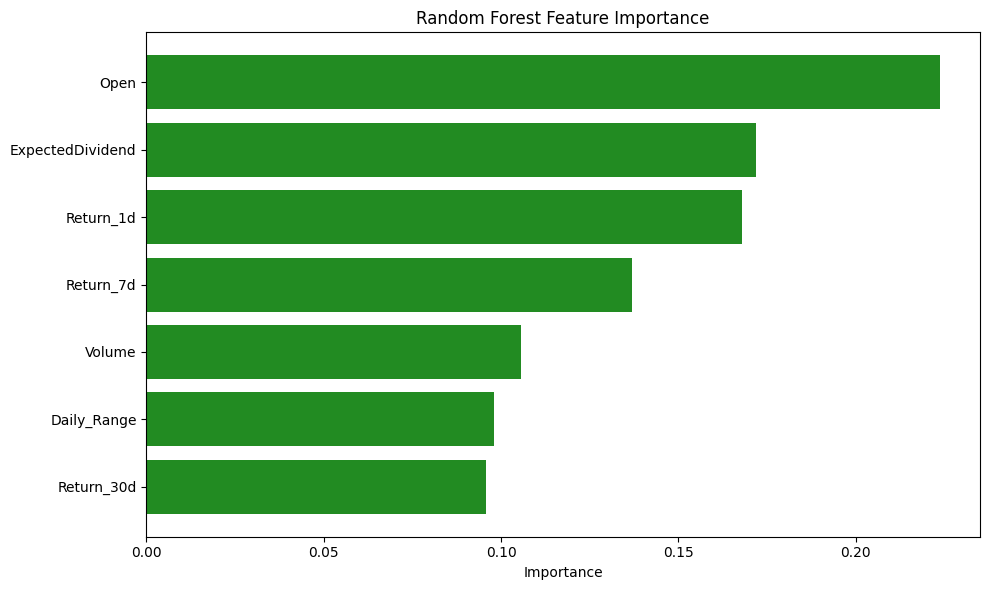

In [28]:
import matplotlib.pyplot as plt

feature_names = X_train_reduced.columns.tolist()
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_reduced.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
def calculate_sharpe_ratio(test_df, predictions, portfolio_size=200, toprank_weight_ratio=2):
    """
    Correct JPX Competition Sharpe Ratio with weighted returns.
    """
    df_eval = test_df.copy()
    df_eval['Prediction'] = predictions

    daily_spread_returns = []

    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)

    for date in df_eval['Date'].unique():
        day_data = df_eval[df_eval['Date'] == date].copy()

        if len(day_data) >= portfolio_size * 2:
            day_data['Rank'] = day_data['Prediction'].rank(ascending=False) - 1
            day_data = day_data.sort_values('Rank')

            top_returns = day_data.head(portfolio_size)['Target'].values
            purchase = (top_returns * weights).sum() / weights.sum()

            bottom_returns = day_data.tail(portfolio_size)['Target'].values[::-1]
            short = (bottom_returns * weights).sum() / weights.sum()

            spread_return = purchase - short
            daily_spread_returns.append(spread_return)

    daily_spread_returns = np.array(daily_spread_returns)

    if len(daily_spread_returns) > 0 and daily_spread_returns.std() > 0:
        sharpe = daily_spread_returns.mean() / daily_spread_returns.std()
    else:
        sharpe = 0

    return sharpe, daily_spread_returns

sharpe, spread_returns = calculate_sharpe_ratio(test_df, y_pred_reduced)

print("JPX Sharpe Ratio:", sharpe)
print("Mean daily spread:", spread_returns.mean())
print("Std daily spread:", spread_returns.std())
print("Days evaluated:", len(spread_returns))

JPX Sharpe Ratio: 0.3368000762731933
Mean daily spread: 0.002798754767424423
Std daily spread: 0.008309840064151976
Days evaluated: 253


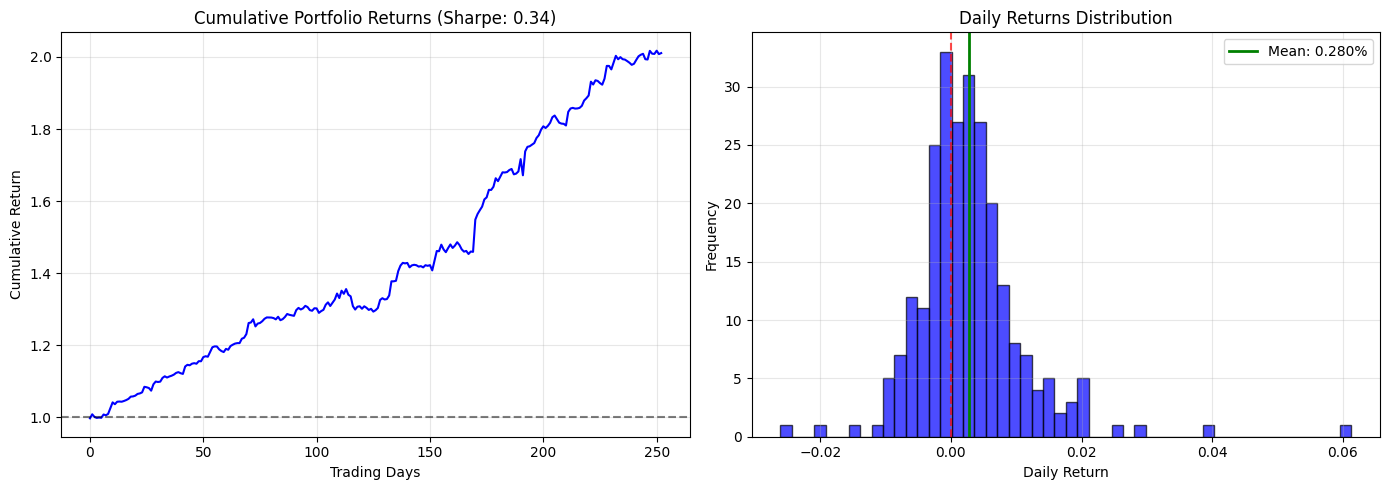

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns
ax1 = axes[0]
cumulative = (1 + pd.Series(spread_returns)).cumprod()
ax1.plot(cumulative, color='blue', linewidth=1.5)
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax1.set_title(f'Cumulative Portfolio Returns (Sharpe: {sharpe:.2f})')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)

# Daily returns distribution
ax2 = axes[1]
ax2.hist(spread_returns, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax2.axvline(x=np.mean(spread_returns), color='green', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(spread_returns)*100:.3f}%')
ax2.set_title('Daily Returns Distribution')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
remove_features = ['ExpectedDividend', 'Return_1d']
remaining_features = [col for col in X_train.columns if col not in remove_features]

print(f"Original features: {len(X_train.columns)}")
print(f"Removed: {remove_features}")
print(f"Remaining features ({len(remaining_features)}): {remaining_features}")

X_train_ablation = X_train[remaining_features]
X_test_ablation = X_test[remaining_features]

rf_ablation = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_ablation.fit(X_train_ablation, y_train)
y_pred_ablation = rf_ablation.predict(X_test_ablation)

r2_ablation = r2_score(y_test, y_pred_ablation)
rmse_ablation = np.sqrt(mean_squared_error(y_test, y_pred_ablation))

Original features: 16
Removed: ['ExpectedDividend', 'Return_1d']
Remaining features (14): ['Open', 'High', 'Low', 'Close', 'Volume', 'SupervisionFlag', 'Daily_Range', 'Mean', 'Return_7d', 'Return_30d', 'Volatility_7', 'Volatility_30', 'Volume_Avg_7', 'Volume_Avg_30']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.2s finished


In [32]:
print("R^2:", r2_ablation)
print("RMSE:", rmse_ablation)

R^2: -0.0004170189717997985
RMSE: 0.024782449783322922


Feature Importance:
            Feature  Importance
8         Return_7d    0.153549
0              Open    0.140008
6       Daily_Range    0.128522
9        Return_30d    0.108909
4            Volume    0.079058
13    Volume_Avg_30    0.064940
12     Volume_Avg_7    0.064245
11    Volatility_30    0.061690
7              Mean    0.056246
10     Volatility_7    0.047763
3             Close    0.035089
2               Low    0.027318
1              High    0.024408
5   SupervisionFlag    0.008255


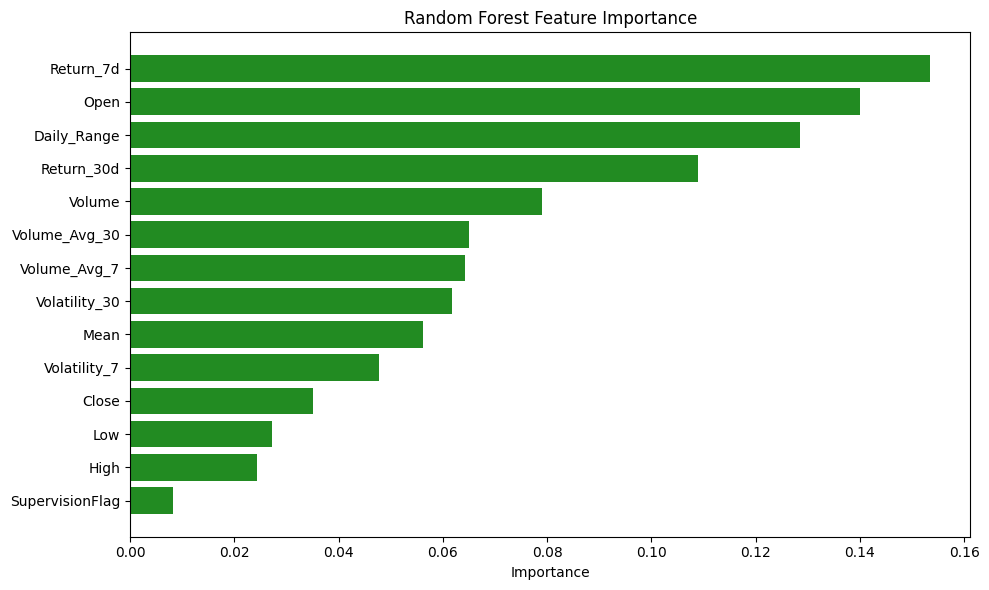

In [33]:
import matplotlib.pyplot as plt

feature_names = X_train_ablation.columns.tolist()
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_ablation.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [34]:
def calculate_sharpe_ratio(test_df, predictions, portfolio_size=200, toprank_weight_ratio=2):
    """
    Correct JPX Competition Sharpe Ratio with weighted returns.
    """
    df_eval = test_df.copy()
    df_eval['Prediction'] = predictions

    daily_spread_returns = []

    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)

    for date in df_eval['Date'].unique():
        day_data = df_eval[df_eval['Date'] == date].copy()

        if len(day_data) >= portfolio_size * 2:
            day_data['Rank'] = day_data['Prediction'].rank(ascending=False) - 1
            day_data = day_data.sort_values('Rank')

            top_returns = day_data.head(portfolio_size)['Target'].values
            purchase = (top_returns * weights).sum() / weights.sum()

            bottom_returns = day_data.tail(portfolio_size)['Target'].values[::-1]
            short = (bottom_returns * weights).sum() / weights.sum()

            spread_return = purchase - short
            daily_spread_returns.append(spread_return)

    daily_spread_returns = np.array(daily_spread_returns)

    if len(daily_spread_returns) > 0 and daily_spread_returns.std() > 0:
        sharpe = daily_spread_returns.mean() / daily_spread_returns.std()
    else:
        sharpe = 0

    return sharpe, daily_spread_returns

sharpe, spread_returns = calculate_sharpe_ratio(test_df, y_pred_ablation)

print("JPX Sharpe Ratio:", sharpe)
print("Mean daily spread:", spread_returns.mean())
print("Std daily spread:", spread_returns.std())
print("Days evaluated:", len(spread_returns))

JPX Sharpe Ratio: 0.12113766554847913
Mean daily spread: 0.0009647350393666064
Std daily spread: 0.007963956008220422
Days evaluated: 253


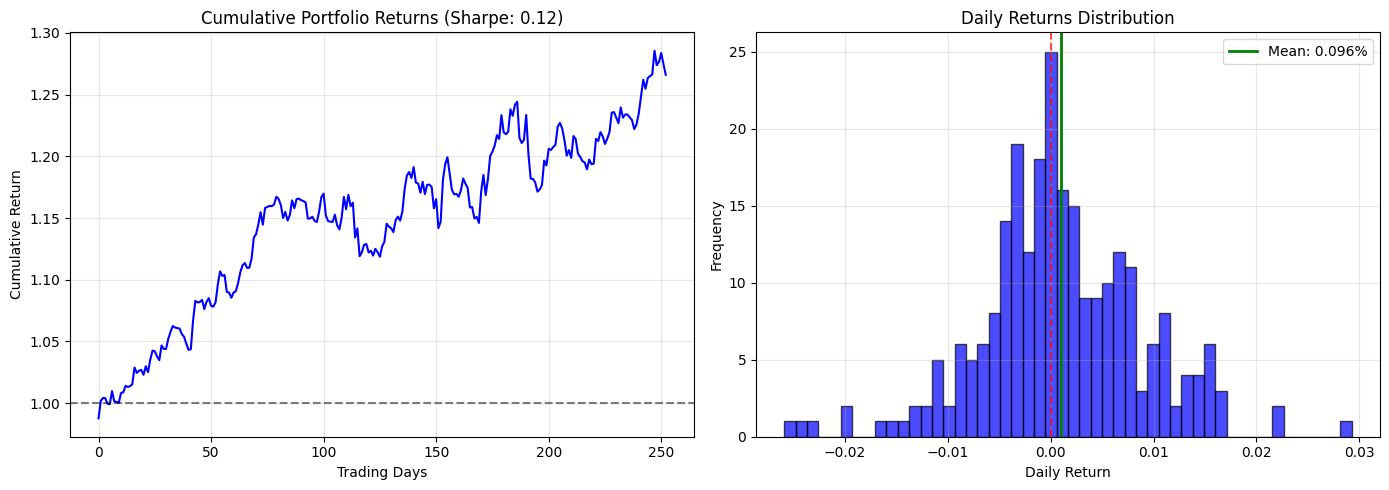

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns
ax1 = axes[0]
cumulative = (1 + pd.Series(spread_returns)).cumprod()
ax1.plot(cumulative, color='blue', linewidth=1.5)
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax1.set_title(f'Cumulative Portfolio Returns (Sharpe: {sharpe:.2f})')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)

# Daily returns distribution
ax2 = axes[1]
ax2.hist(spread_returns, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax2.axvline(x=np.mean(spread_returns), color='green', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(spread_returns)*100:.3f}%')
ax2.set_title('Daily Returns Distribution')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()